# Identify faces using the BNN classifier

Identify people using the BNN classifier.

There are three options:

1. cnvW1A1
2. lfcW1A1
3. lfcW1A2

Set the value of NET to **1** for **cnvW1A2**, **2** for **lfcW1A1** or **3** for **lfcW1A2**.

In [1]:
NET = 1

# Constants, imports and functions

Declare constants.

In [2]:
# Storage configuration
DATA_PATH = "data"
PICKLE_PATH = f"{DATA_PATH}/pickle"
PICKLE_FILE = f"{PICKLE_PATH}/faces.pkl"
PYTHON_PATH = "/usr/local/lib/python3.6"
PYTHON_PKG_PATH = f"{PYTHON_PATH}/dist-packages"
BNN_PATH = f"{PYTHON_PKG_PATH}/bnn"
YALE_PATH = f"{DATA_PATH}/img/yale_faces"
TMP_FILE = "/dev/shm/tmp_file"

# Classifier configuration
LFC = NET > 1
BNN_CLASSIFIER = "facial_recognition"
ACTIVATION = 2 if NET == 3 else 1

# Image configuration
RESOLUTION = 28

Import the BNN library and other necessary modules.

In [3]:
import bnn
import pickle
from PIL import Image

Define functions to pre-process images before classifying them.

In [4]:
def format_lfc_img(img):
    img = np.array(img)
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (RESOLUTION, RESOLUTION), fx = 0.1, fy = 0.1)
    face_array = array.array('B')  

    for x in range(RESOLUTION):  
        for y in range(RESOLUTION):  
            face_array.append(img[y, x])

    # configure header of the MNIST format file         
    hexval = "{0:#0{1}x}".format(1,6)  
    header = array.array('B')  
    header.extend([0, 0, 8, 1, 0, 0])  
    header.append(int('0x' + hexval[2:][:2], 16))  
    header.append(int('0x' + hexval[2:][2:], 16))  
    header.extend([0, 0, 0, RESOLUTION, 0, 0, 0, RESOLUTION])  
    header[3] = 3 # Changing MSB for image data (0x00000803)  
    face_array = header + face_array  
    with open(TMP_FILE, "wb") as f:
        # the classifier will read it the file, which is in memory
        face_array.tofile(f)
    return img

def format_cnv_img(img):
    img.thumbnail((64, 64), Image.ANTIALIAS)
    return img

def format_img(img):
    return format_lfc_img(img) if LFC else format_cnv_img(img)

# Image loading
Run either **option 1** to continue with the previous notebooks, or **option 2** to load a new one.

## Option 1
Load the first crop of the ones created in the previous notebooks.

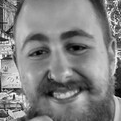

In [5]:
img = []
with open(PICKLE_FILE, "rb") as f:
    img = pickle.load(f)[0]
img = Image.fromarray(img)
img

## Option 2
Load a face from the Yale Faces dataset and prepare it for the classifier.

In [6]:
import array
import cv2
import numpy as np
from os import listdir
from random import randint
import re

Select a random image from the yale faces.

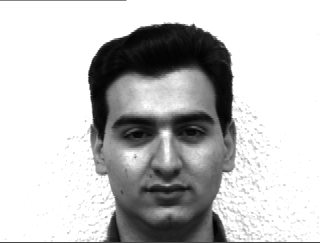

In [7]:
yale_imgs = listdir(YALE_PATH)
img_path = f"{YALE_PATH}/{yale_imgs[randint(0, len(yale_imgs)-1)]}"
img = Image.open(img_path)
img

Format the image.

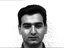

In [8]:
img = format_img(img)
Image.fromarray(img) if type(img) is np.ndarray else img

# Clasification

Load the classifier.

In [9]:
if LFC:
    topology = bnn.NETWORK_LFCW1A2 if ACTIVATION == 2 else bnn.NETWORK_LFCW1A1
    hw_classifier = bnn.LfcClassifier(topology, BNN_CLASSIFIER, bnn.RUNTIME_HW)
else:
    hw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1, BNN_CLASSIFIER, bnn.RUNTIME_HW)

Run the classifier. The output number is the index of the identified person. Indices where assigned when training the model.

In [10]:
if LFC:
    class_out = hw_classifier.classify_mnist(TMP_FILE)
else:
    class_out = hw_classifier.classify_images([img])[0]
print("Class name: {0}".format(hw_classifier.class_name(class_out)))

Inference took 528.00 microseconds, 528.00 usec per image
Classification rate: 1893.94 images per second
Class name: Person 6


# Cleanup

Before switching to another notebook the cleanup code must be run.

In [11]:
from pynq import Xlnk

xlnk = Xlnk()
xlnk.xlnk_reset()

#  